In [20]:
import numpy as np
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import os
from datetime import datetime


from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#data location path
PROJECT_DIR = "C:/Users/Yazhi/Desktop"

TEST_DIR = os.path.join(PROJECT_DIR, "Test")
LOG_DIR = os.path.join(PROJECT_DIR, "Log")
TIMESTAMP = "{0:%Y-%m-%dT%H-%M-%S/}".format(datetime.now())

seed        = 29
np.random.seed(seed)

In [21]:
test_file_count = sum([len(files) for r, d, files in os.walk(TEST_DIR)])
print("Testing images: ", test_file_count)

Testing images:  7


# Setup Model

In [22]:
img_rows = 64
img_cols = 64
epochs = 200
batch_size = 32

optmz       = optimizers.Adam(lr=0.001)

In [23]:
# resLyr
def resLyr(inputs,
           numFilters=16,
           kernelSz=3,
           strides=1,
           activation='relu',
           batchNorm=True,
           convFirst=True,
           lyrName=None):
    convLyr = Conv2D(numFilters,
                       kernel_size=kernelSz,
                       strides=strides,
                       padding='same',
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4),
                       name=lyrName+'_conv' if lyrName else None)
    x = inputs
    if convFirst:
        x = convLyr(x)
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
    else:
        if batchNorm:
            x = BatchNormalization(name=lyrName+'_bn' if lyrName else None)(x)
        if activation is not None:
            x = Activation(activation,name=lyrName+'_'+activation if lyrName else None)(x)
        x = convLyr(x)

    return x

# resBlkV1
def resBlkV1(inputs,
             numFilters=16,
             numBlocks=3,
             downsampleOnFirst=True,
             names=None):
    x = inputs
    
    for run in range(0,numBlocks):
        strides = 1
        blkStr = str(run+1)

        if downsampleOnFirst and run == 0:
            strides = 2

        y = resLyr(inputs=x,
                   numFilters=numFilters,
                   strides=strides,
                   lyrName=names+'_Blk'+blkStr+'_Res1' if names else None)
        y = resLyr(inputs=y,
                   numFilters=numFilters,
                   activation=None,
                   lyrName=names+'_Blk'+blkStr+'_Res2' if names else None)
        
        if downsampleOnFirst and run == 0:
            x = resLyr(inputs=x,
                        numFilters=numFilters,
                        kernelSz=1,
                        strides=strides,
                        activation=None,
                        batchNorm=False,
                        lyrName=names+'_Blk'+blkStr+'_lin' if names else None)
            
        x = add([x,y],name=names+'_Blk'+blkStr+'_add' if names else None)
        x = Activation('relu',name=names+'_Blk'+blkStr+'_relu' if names else None)(x)

    return x

In [24]:
# createResNetV1
def createResNetV1(inputShape=(img_rows,img_cols,3),
                   numClasses=3):
    inputs = Input(shape=inputShape)
    v = resLyr(inputs, lyrName='Inpt')
    v = resBlkV1(v,16,3,False,'Stg1')
    v = resBlkV1(v,32,3,True,'Stg2')
    v = resBlkV1(v,64,3,True,'Stg3')
    
    v = resLyr(inputs=v,
            numFilters=64,
            kernelSz=3,
            strides=1,
            activation='relu',
            batchNorm=True,
            convFirst=True,
            lyrName='v4.2'
            )

    v = AveragePooling2D(pool_size=4,name='AvgPool')(v)
    v = Flatten()(v)
    v = Dense(128)(v)
    outputs = Dense(numClasses,activation='softmax',kernel_initializer='he_normal')(v)
    model = Model(inputs=inputs,outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                    optimizer=optmz,
                    metrics=['accuracy'])

    return model

# set up model
testingModel       = createResNetV1()  # This is meant for training

testingModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
Inpt_conv (Conv2D)              (None, 64, 64, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
Inpt_bn (BatchNormalizationV1)  (None, 64, 64, 16)   64          Inpt_conv[0][0]                  
__________________________________________________________________________________________________
Inpt_relu (Activation)          (None, 64, 64, 16)   0           Inpt_bn[0][0]                    
__________________________________________________________________________________________________
Stg1_Blk1_

In [25]:
testingModel.load_weights('CA2_Final_Model.hdf5')
testingModel.compile(loss='categorical_crossentropy',
                    optimizer=optmz,
                    metrics=['accuracy'])

In [82]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

def predictImage(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    
    image = cv2.imread(path)
    image = cv2.resize(image, (64, 64))
    features = np.swapaxes(np.swapaxes(image, 1, 2), 0 ,1).reshape(1, 64, 64, 3)
    
    predicts = testingModel.predict(features)
    
    label = 'Food'
    if predicts[0][1] > predicts[0][0]:
        if predicts[0][1] > predicts[0][2]:
            label = 'Landmark'
        else:
            label = 'People'
            
    print(label)

classified label for test image 1 is People


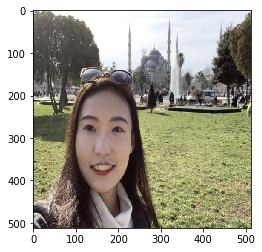

In [100]:
test1 = 'C:/Users/Yazhi/Desktop/Test/test1.jpg'
print("classified label for test image 1 is",predictImage(test1))

classified label for test image 2 is Landmark


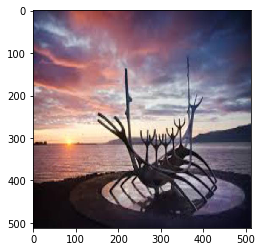

In [92]:
test2 = 'C:/Users/Yazhi/Desktop/Test/test2.jpg'
print("classified label for test image 2 is",predictImage(test2))

classified label for test image 3 is Landmark


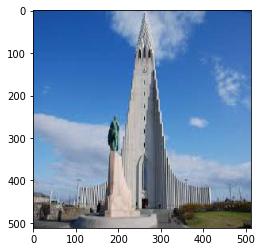

In [93]:
test3 = 'C:/Users/Yazhi/Desktop/Test/test3.jpg'
print("classified label for test image 3 is",predictImage(test3))

classified label for test image 4 is People


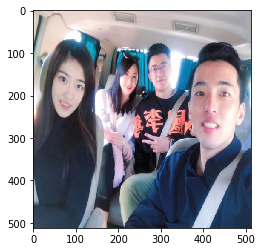

In [94]:
test4 = 'C:/Users/Yazhi/Desktop/Test/test4.jpg'
print("classified label for test image 4 is",predictImage(test4))

classified label for test image 5 is Food


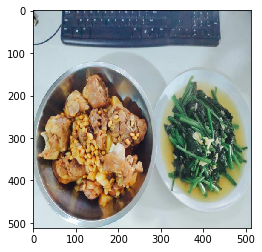

In [97]:
test5 = 'C:/Users/Yazhi/Desktop/Test/test5.jpg'
print("classified label for test image 5 is",predictImage(test5))

classified label for test image 6 is Food


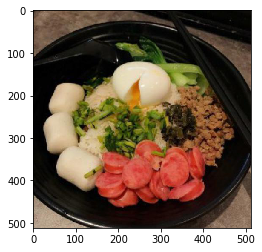

In [95]:
test6 = 'C:/Users/Yazhi/Desktop/Test/test6.jpg'
print("classified label for test image 6 is",predictImage(test6))

classified label for test image 7 is Food


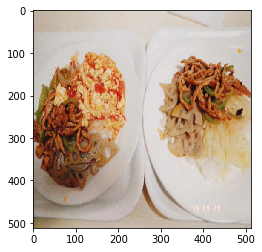

In [96]:
test7 = 'C:/Users/Yazhi/Desktop/Test/test7.jpg'
print("classified label for test image 7 is",predictImage(test7))